## Importing libraries

In [1]:
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Web scraping from: https://wine.com
**The url_constructor function takes a page number and a URL as input, and it returns a new URL by splitting the original URL around the string**

In [2]:
def url_contructor(page_number, url):
    first = url.split('7155', 1)[0]
    second = url.split('7155',1)[1]
    url = first + '7155/' + str(page_number) + second
    return url

**The web_scrap function is a web scraper that collects data from a website that displays information about wine products.**

In [3]:
def web_scrap():
    page = 0
    url_df = []
    web_data = {'product_name': [],
                'year': [],
                'varietal': [],
                'origin': [],
                'price': [],
                'abv': [],
                'rating': [],
                'rating_count': [],
                'reviews': []
                }
    df = pd.DataFrame(data=web_data)
    url = 'https://www.wine.com/list/wine/7155?pricemin=10'
    for x in range(1, 520):
        try:
            page += 1
            url_df.append(url_contructor(page, url))
        except Exception:
            continue
    for link in tqdm(url_df):
        r = requests.get(link)
        soup = BeautifulSoup(r.content, 'html.parser')
        all_li = soup.find_all('li', {'class': 'prodItem'})
        for li in all_li:
            try:
                product_name = li.find('span', class_='prodItemInfo_name').string
                year = product_name.split()[-1]
                product_name = product_name.rsplit(' ', 1)[0]
                price = li.find('span', class_='productPrice_price-regWhole').string
                varietal = li.find('span', class_='prodItemInfo_varietal').string
                origin = li.find('span', class_='prodItemInfo_originText').string
                origin = origin.split()[-1]
                rating = li.find('span', class_='averageRating_average').string
                rating_count = li.find('span', class_='averageRating_number').string
                wine_link = li.find('a', class_='prodItemInfo_link event_productClick')
                wine_link = wine_link['href'].strip("'")
                r2 = requests.get(f'https://www.wine.com{wine_link}')
                soup2 = BeautifulSoup(r2.content, 'html.parser')
                abv = soup2.find('span', class_='prodAlcoholPercent_percent').string
                reviews = soup2.find_all('div', class_='pipProfessionalReviews_list')
                notes = ""
            except Exception:
                break
            for review in reviews:
                try:
                    rev = review.find('div', class_ ='pipSecContent_copy').string
                    if rev != None:
                        notes+= rev + " "
                except Exception:
                    break
            series = [product_name, year, varietal, origin, price, abv, rating, rating_count, notes]
            df.loc[len(df)] = np.asarray(series, dtype=object)
    return df

**Run this command to update the DataFrame**

In [4]:
#df = web_scrap()

**Run this command to save the DataFrame**

In [5]:
#df.to_csv('wine.csv')

**Load the DataFrame**

In [6]:
df = pd.read_csv('wine.csv', index_col=0)
df

,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews
0,Veuve Clicquot Yellow Label Brut with Gold Gift,Box,Mixed Collections,Other,84,0.0,0.0,0,NaN
1,2018 Silver Oak Alexander Valley Cabernet Sauv...,Box,Mixed Collections,Other,99,0.0,0.0,0,NaN
2,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,90,COMMENTARY: The 2019 Duckhorn Vineyards Cabern...
3,Veuve Clicquot Yellow Label,Brut,Non-Vintage Sparkling Wine,France,69,12.0,4.5,1748,"Toasty and generous with lemon freshness, this..."
4,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,20,The purity of fruit is really something else h...
...,...,...,...,...,...,...,...,...,...
10830,Ettore Germano Barolo Cerretta,2017,Nebbiolo,Italy,79,14.5,0.0,0,"Bright and charming, this strawberry- and cher..."
10831,Domaine du Vieux Telegraphe Chateauneuf-du-Pap...,2019,Rhone Red Blends,France,209,14.5,0.0,0,If anyone tells you that Châteauneuf is just a...
10832,Alamos Mendoza Seleccion Malbec,2019,Malbec,Argentina,18,0.0,3.6,7,NaN
10833,Movia Veliko Rosso,2012,Bordeaux Red Blends,Slovenia,67,0.0,0.0,0,NaN


# Cleaning data for plots and machine learning

**Display the entire 'reviews' column**

In [7]:
with pd.option_context('display.max_colwidth', -1):
    display(df[['reviews']])

,reviews
0,NaN
1,NaN
2,"COMMENTARY: The 2019 Duckhorn Vineyards Cabernet Sauvignon is lovely and shows excellent staying power on the palate. TASTING NOTES: This wine offers beautiful aromas and flavors of ripe cherries, black fruits, and complimentary oak nuances. Try it with a grilled, well-marbled ribeye. (Tasted: December 28, 2021, San Francisco, CA) Aromas of wet stone, gravel and blackcurrant. Full-bodied with fine, velvety tannins. Juicy, bright and fresh. Lovely dark fruit, with gravel and wet-stone notes adding very nice definition. Chocolate finish. A ripe, polished and direct style, with cassis, blackberry and red cherry puree gliding through, inlaid with light mocha and vanilla accents through the finish. Drink now"
3,"Toasty and generous with lemon freshness, this also has quite some dried-pear and peach aromas from mature elements of the blend, plus a touch of spice at the long, structured finish. The cuvée is based on 2015 and is 50% pinot noir, 30% chardonnay and 20% pinot meunier. Reserve wines make up more than one third of the blend. Drink now. Noticeable fruit intensity and fresh notes of red fruits, fresh blueberries and a small amount of quince. Interesting and quite demanding. Blend : 55% Pinot Noir, 15% Pinot Meunier, 30% Chardonnay One of the most popular of all Champagnes, this is now showing a freshness that wasn't always there. The crisp texture and green-apple flavors give it an immediate drinkability as well as perfumed acidity and a vibrant aftertaste. A crisp and lacy Champagne, with a hint of smoke underscoring flavors of poached apricot, pastry cream and pickled ginger. An overtone of Mandarin orange peel ties it all together."
4,"The purity of fruit is really something else here, with currants and fresh flowers, such as violets and roses. Flower stems as well. Fantastic length and structure to the wine, with tightness and focus. Wonderful fruit. Graceful. A blend of 78% cabernet sauvignon, 8% merlot, 7% petit verdot, 6% cabernet franc and 1% malbec. Try after 2028. Elegantly styled, despite some serious heft, this offers a mix of alluring mulberry, griotte and cassis notes bearing a gently mulled edge, while flashes of apple wood, sweet bay leaf and red tea flicker along the edges. Very refined in feel, with seamless structure extending the finish so the fruit can linger. Cabernet Sauvignon, Petit Verdot, Merlot, Cabernet Franc and Malbec. Drink now"
...,...
10830,"Bright and charming, this strawberry- and cherry-flavored red is light on its feet and mouthwatering, with accents of tar and tobacco adding interest. No pushover, this packs some lively tannins, ending with fine balance and length overall. The Ettore Germano 2017 Barolo Cerretta shows a shiny ruby color and lots of ambient light. The bouquet is nuanced and detailed, with cassis, dried cranberry, camphor ash and crushed flowers. This wine excels in terms of texture, thanks to that twofold combination of structure and elegant silkiness. This is a sharply chiseled and focused Cerretta release of some 75,000 bottles."
10831,"If anyone tells you that Châteauneuf is just a big red that’s never elegant, then they need to taste this masterpiece of elegance. So many spicy and savory nuances on the very concentrated but almost perfectly proportioned palate. This is both joyful and serious at the very long, focused finish. Decades of aging potential! Drink or hold. Saturated ruby. Deep-pitched red/blue fruit liqueur aromas pick up suggestions of licorice, pipe tobacco and pungent flowers and herbs with air. In a lush, weighty style, offering expansive black raspberry, cherry cola, singed plum and fruitcake flavors sharpened by a jolt of spiciness on the back half. For all this wine's richness, it's energetic as well, showing solid, spice- and floral-driven persistence on the finish, which is framed by velvety, even tannins. The 2019 Châteauneuf Du Pape is ruby/purple-hued and has the classic translucent color of the domaine. It's more precis

**Droping all rows in the DataFrame where the "reviews" column is null**

In [8]:
df['reviews'] = df['reviews'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

In [9]:
df['reviews'] = df['reviews'].apply(lambda x: x if x else None)
df = df.dropna(subset=['reviews'])

**Removing any rows where the value in the rating and abv columns is 0, this is done because we want only alcoholic wine, as non-alcoholic wine would have a 0 value for 'abv' column. Then it removes any rows where the value in the rating_count column is less than or equal to 8, this is done to ensure that the data is reliable and accurate, as wines with only 2 reviews would not provide a sufficient sample size to produce an accurate machine learning model.**

In [10]:
df = df[df['rating'] != 0]
df = df[df['abv'] != 0]
df = df[df['rating_count'] > 8]

**Removing any rows where the 'year' column is not a numeric value and converting to a numeric data type. removing any commas from the 'price' column and converting it to an integer, and converting the 'rating' column to a float data type.**

In [11]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
df['price']=df['price'].str.replace(',','')
df = df.astype({'price':'int'})
df = df.astype({'rating':'float'})
df['year'] = pd.to_numeric(df['year'])

**The code filters the DataFrame df by removing any rows where the value in the year column is less than or equal to 2000 or greater than or equal to 2021. This is done to ensure that the dataset only contains relevant data and that any outliers or irrelevant data is removed. This is also important to make sure that the analysis and predictions made using the data is relevant and accurate.** 

In [12]:
df = df[df['year'] > 2000]
df = df[df['year'] < 2021]
df = df.reset_index(drop=True)

**Filter the DataFrame by removing any rows where the value in the varietal column does not appear in at least three other rows, and then remove any rows where the value in the origin column does not appear in at least three other rows**

In [13]:
df = df.groupby('varietal').filter(lambda x : len(x)>2).reset_index(drop=True)
df = df.groupby('origin').filter(lambda x : len(x)>2).reset_index(drop=True)

**Remove duplicates**

In [14]:
df = df.drop_duplicates(subset=['product_name'])

**Add two new columns to the DataFrame, called varietal_code and origin_code, which contain integer codes that represent the values in the varietal and origin columns, respectively**

In [15]:
df['varietal_code'] = df['varietal'].astype('category').cat.codes
df['origin_code'] = df['origin'].astype('category').cat.codes
df = df.reset_index(drop=True)
df

,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews,varietal_code,origin_code
0,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,90,commentary the 2019 duckhorn vineyards caberne...,4,4
1,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,20,the purity of fruit is really something else h...,2,4
2,Silver Oak Alexander Valley Cabernet Sauvignon,2018,Cabernet Sauvignon,California,89,14.4,4.6,31,commentary the silver oak alexander valley one...,4,4
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,82,14.5,4.4,101,cassis dried blueberries violets ink graphite ...,4,4
4,Antinori Marchese Chianti Classico Riserva,2019,Sangiovese,Italy,46,14.0,4.3,11,a harmonious red offering an expression of che...,31,8
...,...,...,...,...,...,...,...,...,...,...,...
721,Serego Alighieri MontePiazzo Valpolicella Clas...,2017,Other Red Blends,Italy,41,13.5,3.7,17,a valpo with lots of crushedberry chocolate an...,20,8
722,Langmeil The Blacksmith Cabernet Sauvignon,2017,Cabernet Sauvignon,Australia,32,14.5,4.2,23,brilliant ruby ripe cherry and blackcurrant ar...,4,2
723,Vinaceous Reverend V Cabernet Sauvignon,2014,Cabernet Sauvignon,Australia,19,14.5,3.5,30,the mintscented 2014 right reverend v cabernet...,4,2
724,Enrique Mendoza Estrecho Monastrell,2016,Mourvedre,Spain,40,14.0,3.8,10,the 2016 estrecho was cropped from a more unus...,15,11


**---------------------------------------------------------------------------------------------------------------------------**

# Plotting some usefull info 

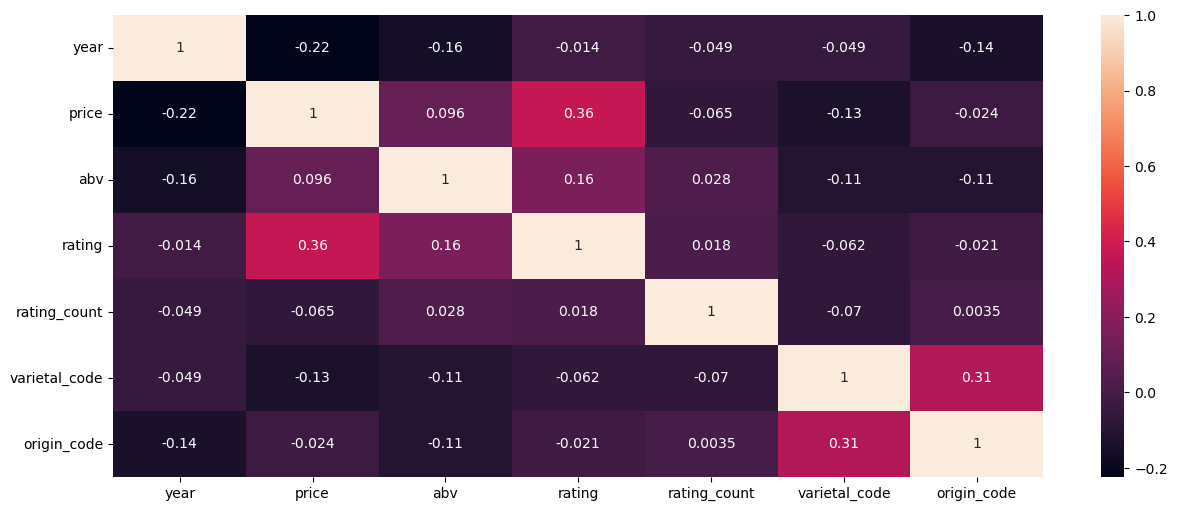

In [16]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(method='pearson', numeric_only=True), annot=True)
plt.show()

### We can see a correlation between the origin and the variety of the wine, and also a correlation between the price and the rating

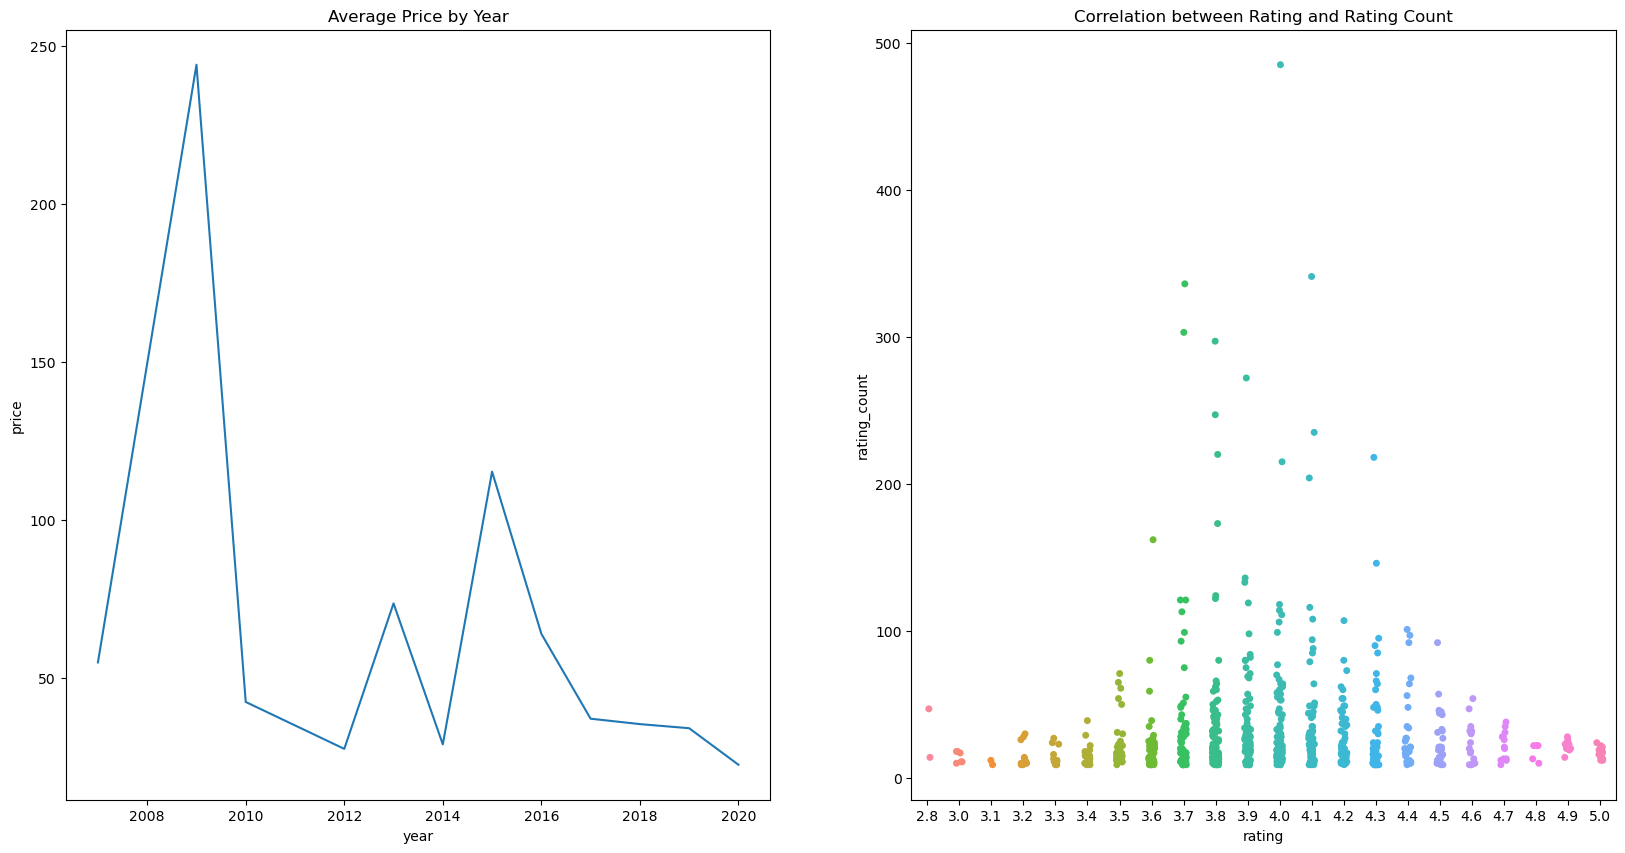

In [17]:
price_by_year = df.groupby('year')['price'].mean().reset_index()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.lineplot(x=price_by_year['year'], y=price_by_year['price'], ax=ax1)
ax1.set_title('Average Price by Year')
sns.stripplot(data=df, x="rating", y="rating_count",ax=ax2)
ax2.set_title('Correlation between Rating and Rating Count')
plt.show()

### The older the wine, the higher the price

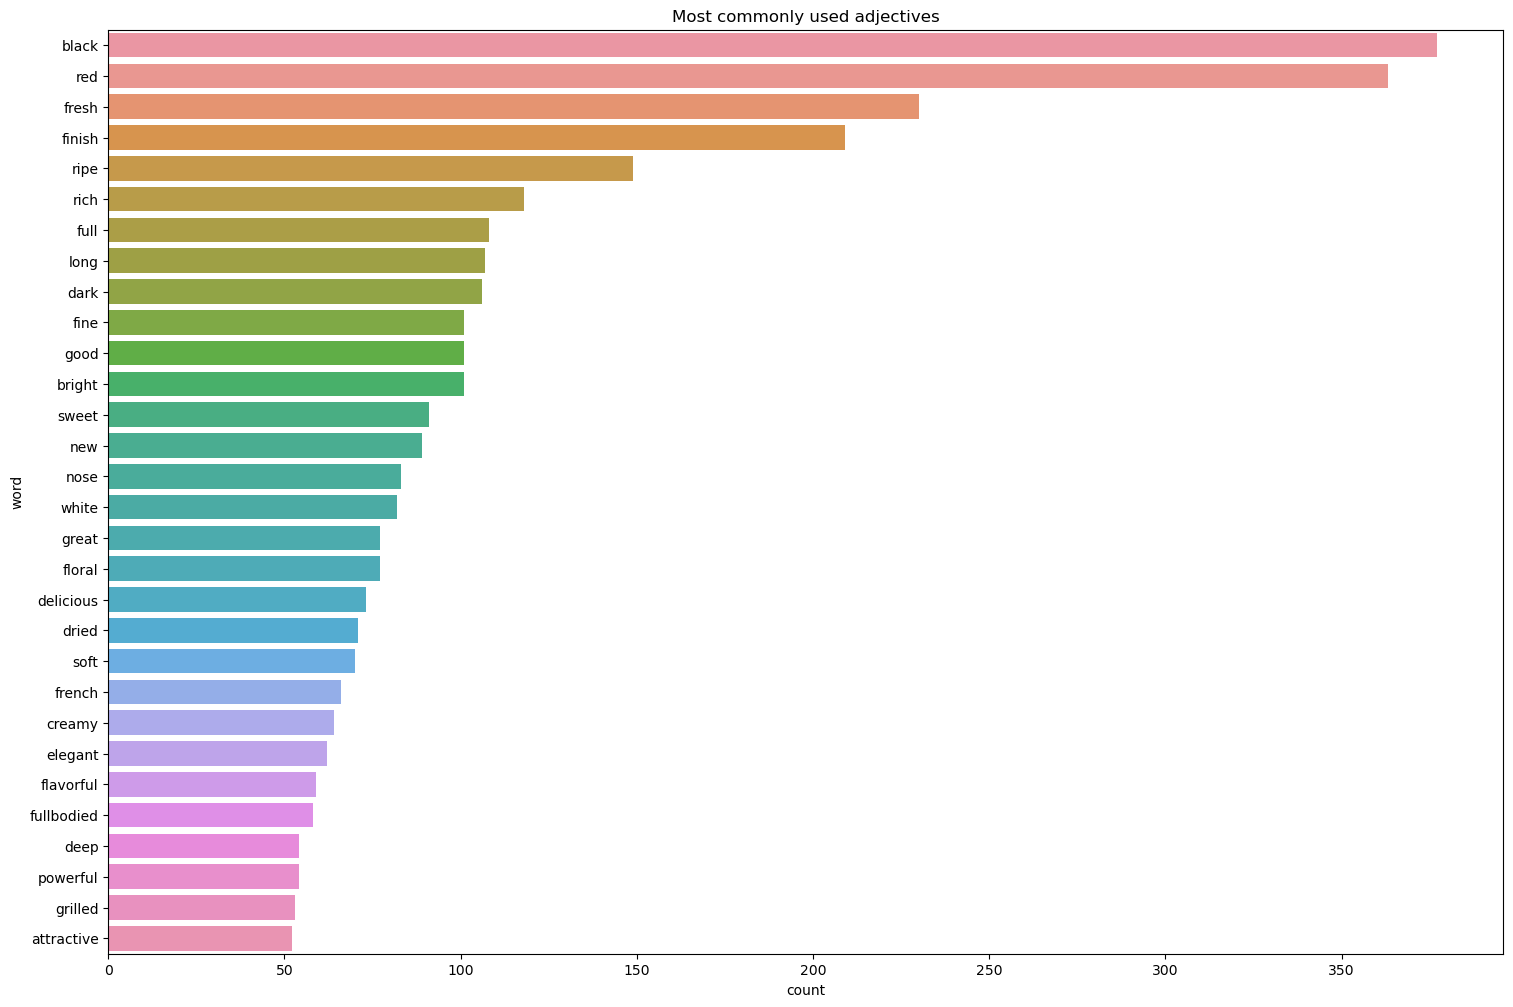

In [18]:
plt.figure(figsize=(18,12))

stop_words = set(stopwords.words("english"))
reviews = df['reviews']
reviews_tokens = reviews.apply(word_tokenize)

filtered_reviews = []
for review in reviews_tokens:
    tagged_words = pos_tag(review)
    adjectives = [word for word, pos in tagged_words if pos == 'JJ']
    filtered_reviews.append(adjectives)

all_words = [word for sublist in filtered_reviews for word in sublist]
fdist = nltk.FreqDist(all_words)
fdist_df = pd.DataFrame(fdist.most_common(30), columns=['word', 'count'])

ax = sns.barplot(x='count', y='word', data=fdist_df)
ax.set_title('Most commonly used adjectives')
plt.show()

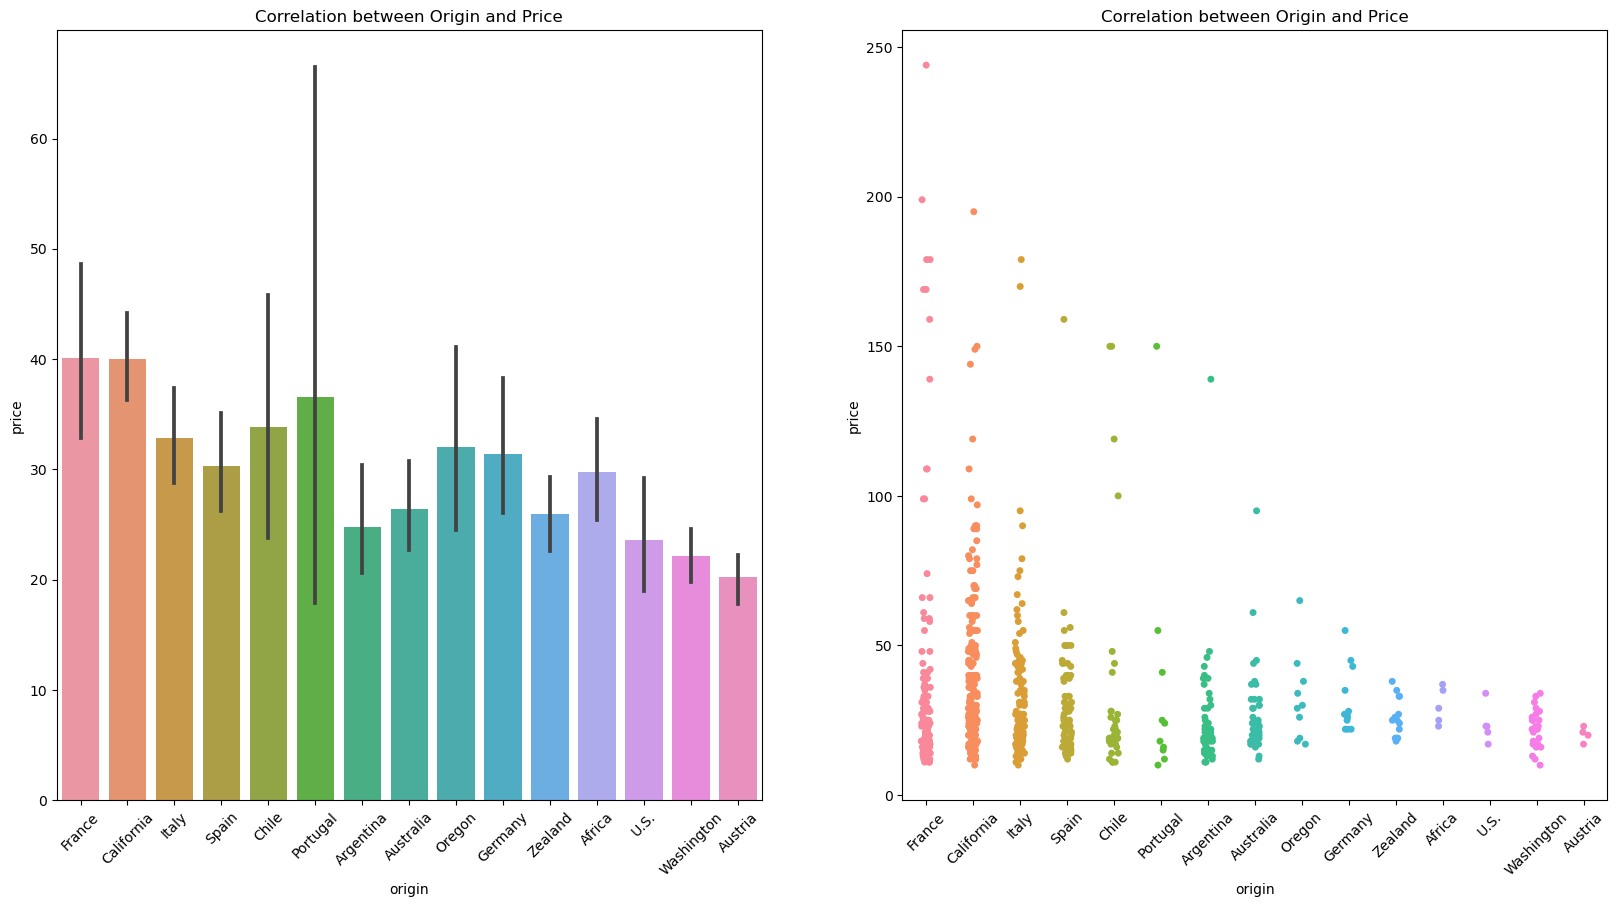

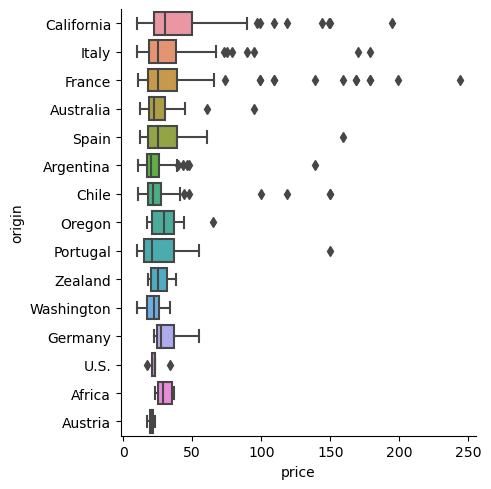

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
df_filtered = df.drop(df[df.price >= 250].index)
df_filtered = df_filtered.sort_values(by='price', ascending=False)
sns.barplot(x = 'origin', y = 'price', data = df_filtered,ax=ax1)
sns.stripplot(data=df_filtered, x="origin", y="price",ax=ax2)
ax1.set_title('Correlation between Origin and Price')
ax2.set_title('Correlation between Origin and Price')

sns.catplot(data=df.drop(df[df.price >= 250].index), x="price", y="origin",kind="box")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

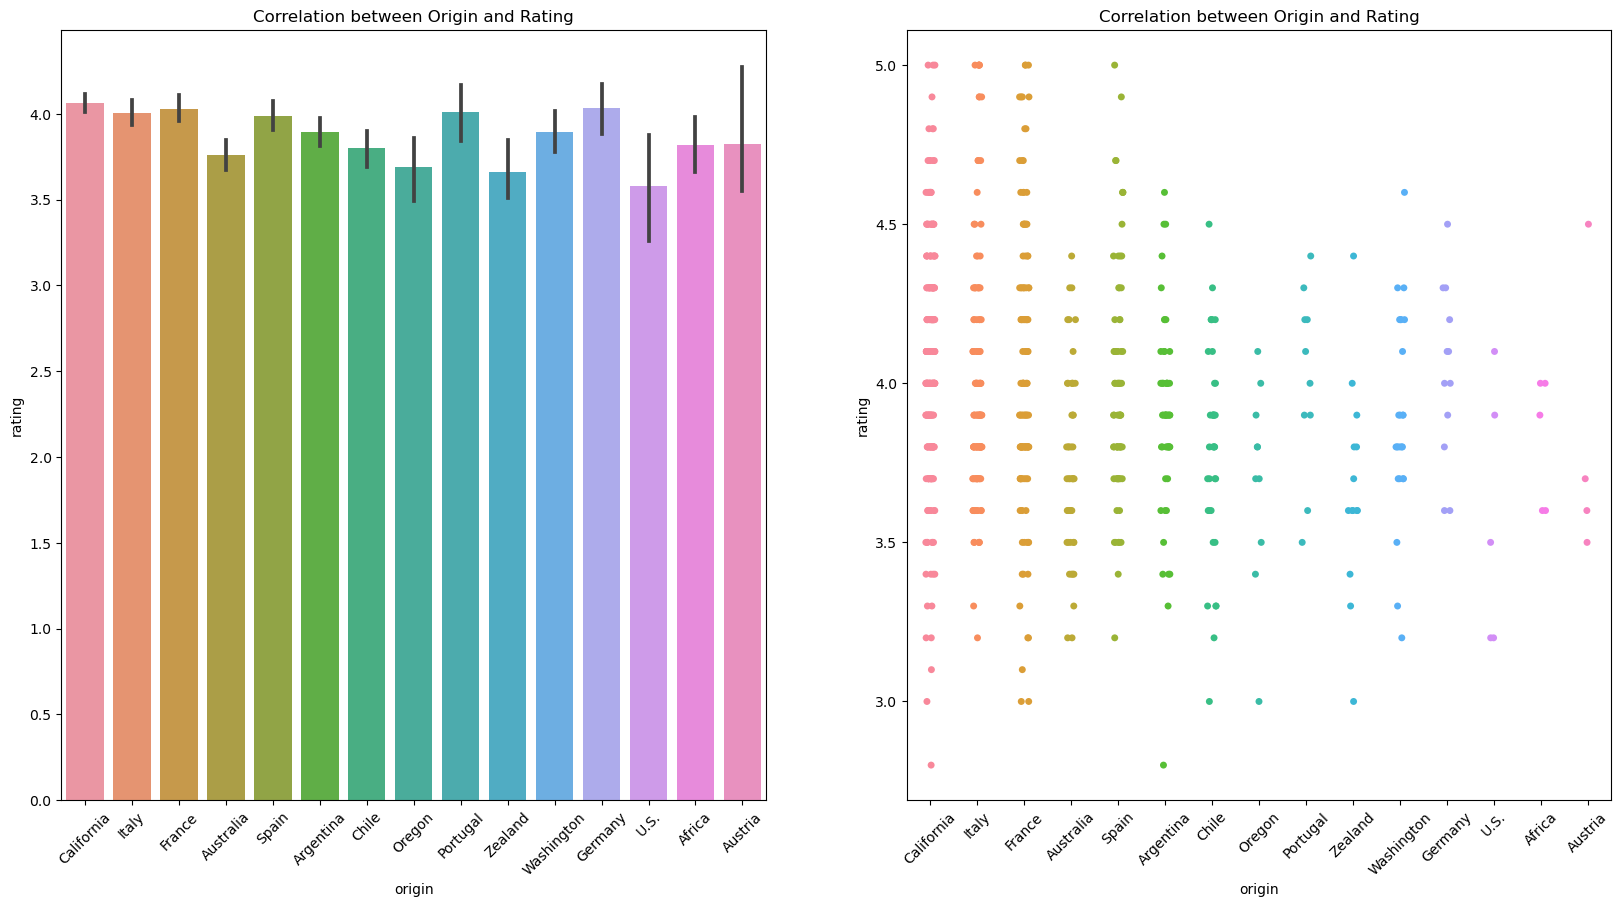

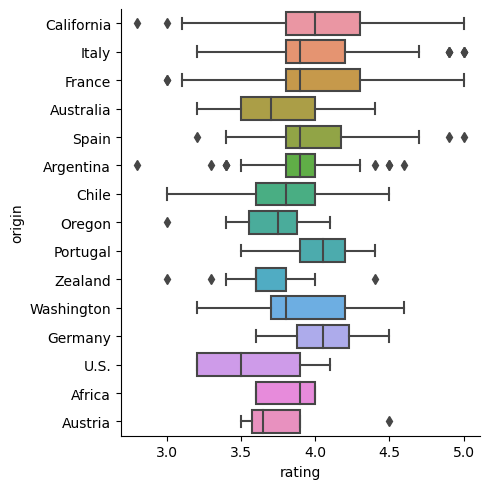

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'rating', data = df,ax=ax1)
sns.stripplot(data=df, x="origin", y="rating",ax=ax2)
ax1.set_title('Correlation between Origin and Rating')
ax2.set_title('Correlation between Origin and Rating')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="rating", y="origin",kind="box")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

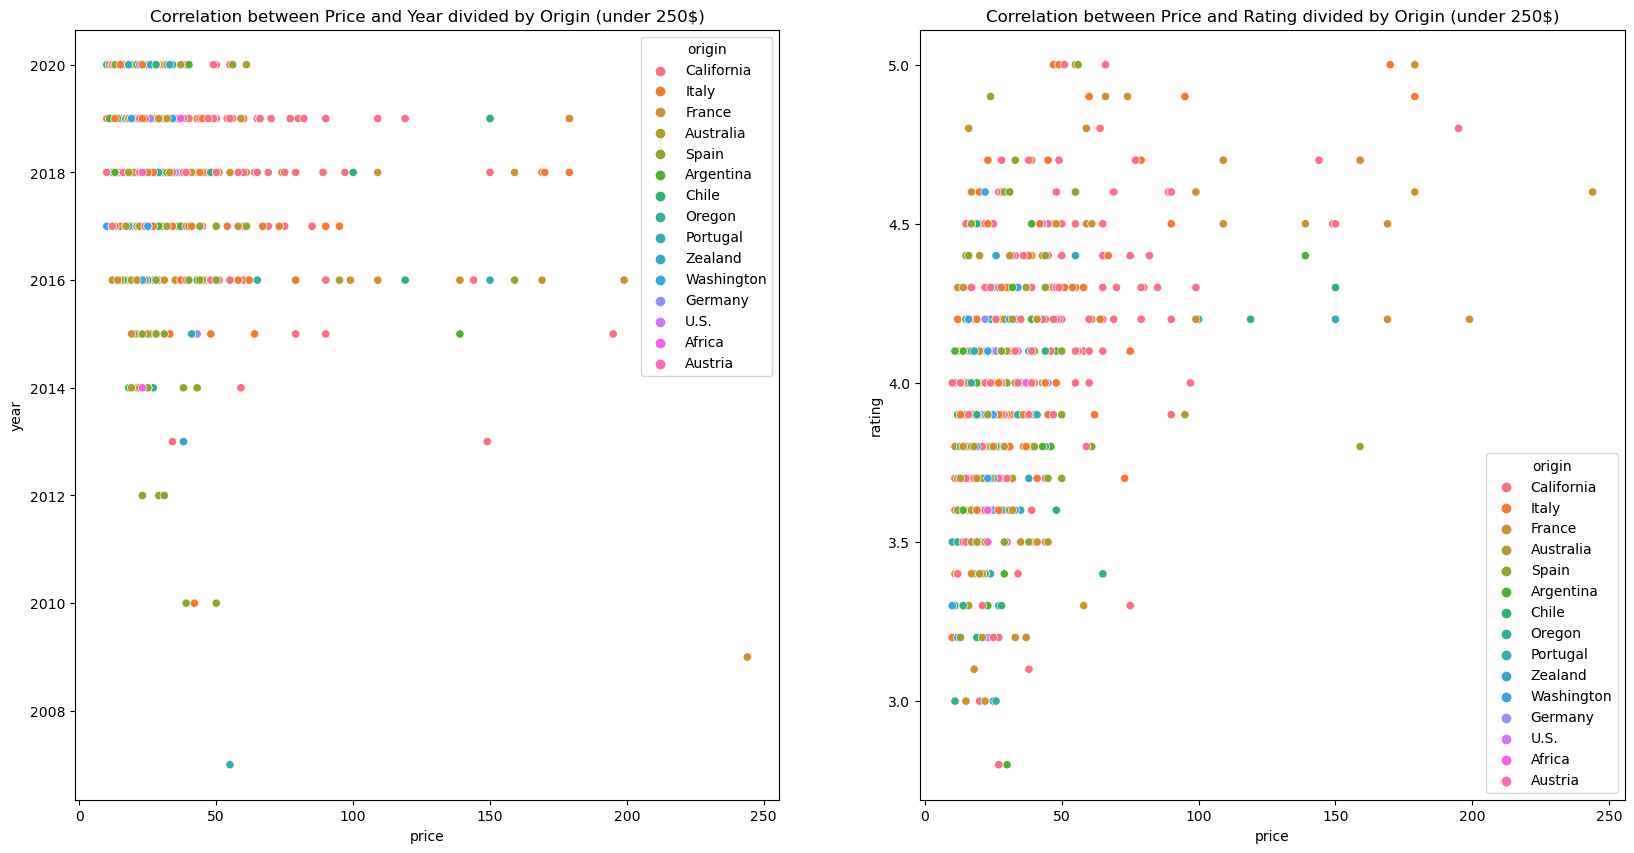

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="year",hue="origin",ax =ax1)
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="rating",hue="origin",ax =ax2)
ax1.set_title('Correlation between Price and Year divided by Origin (under 250$)')
ax2.set_title('Correlation between Price and Rating divided by Origin (under 250$)')
plt.show()

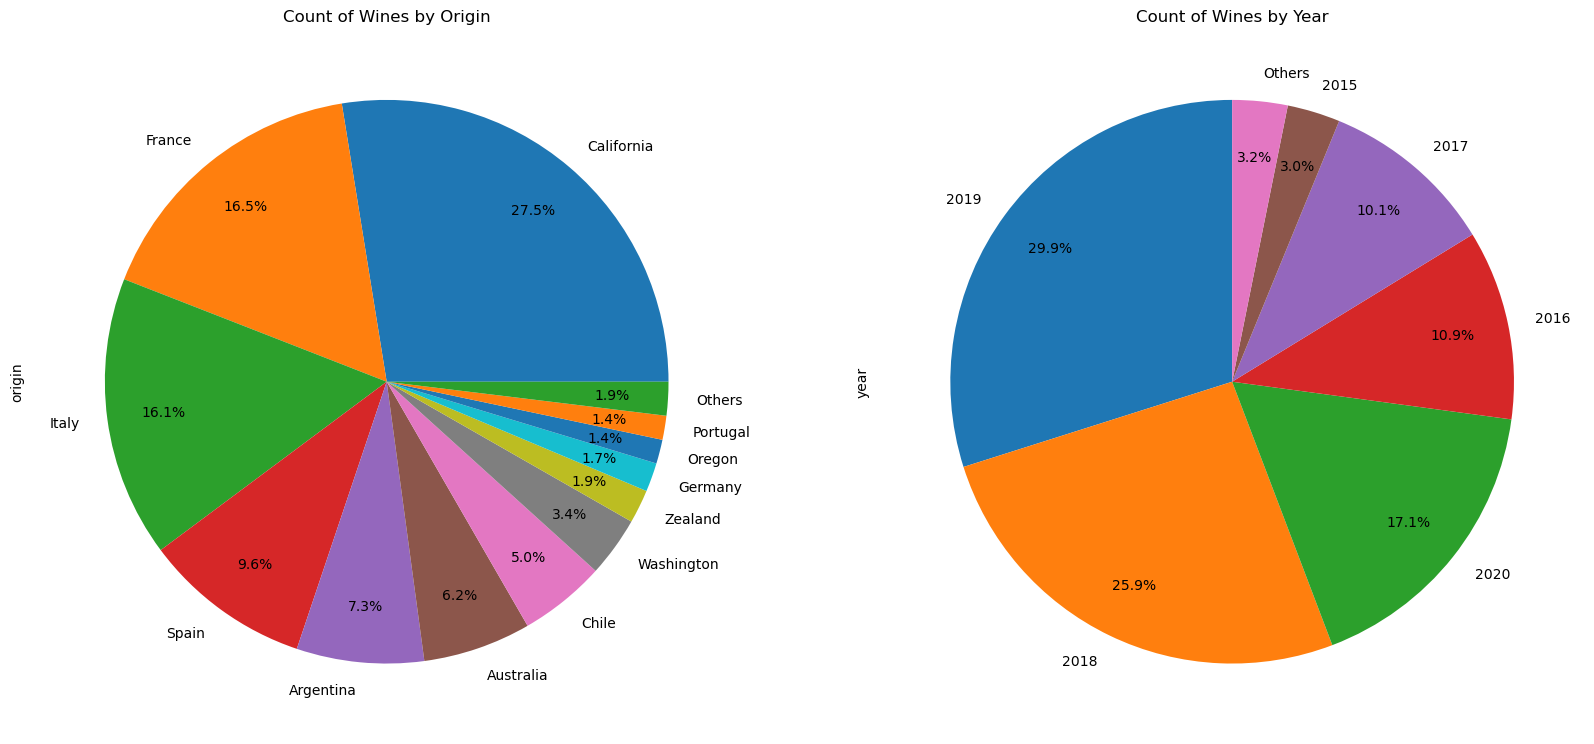

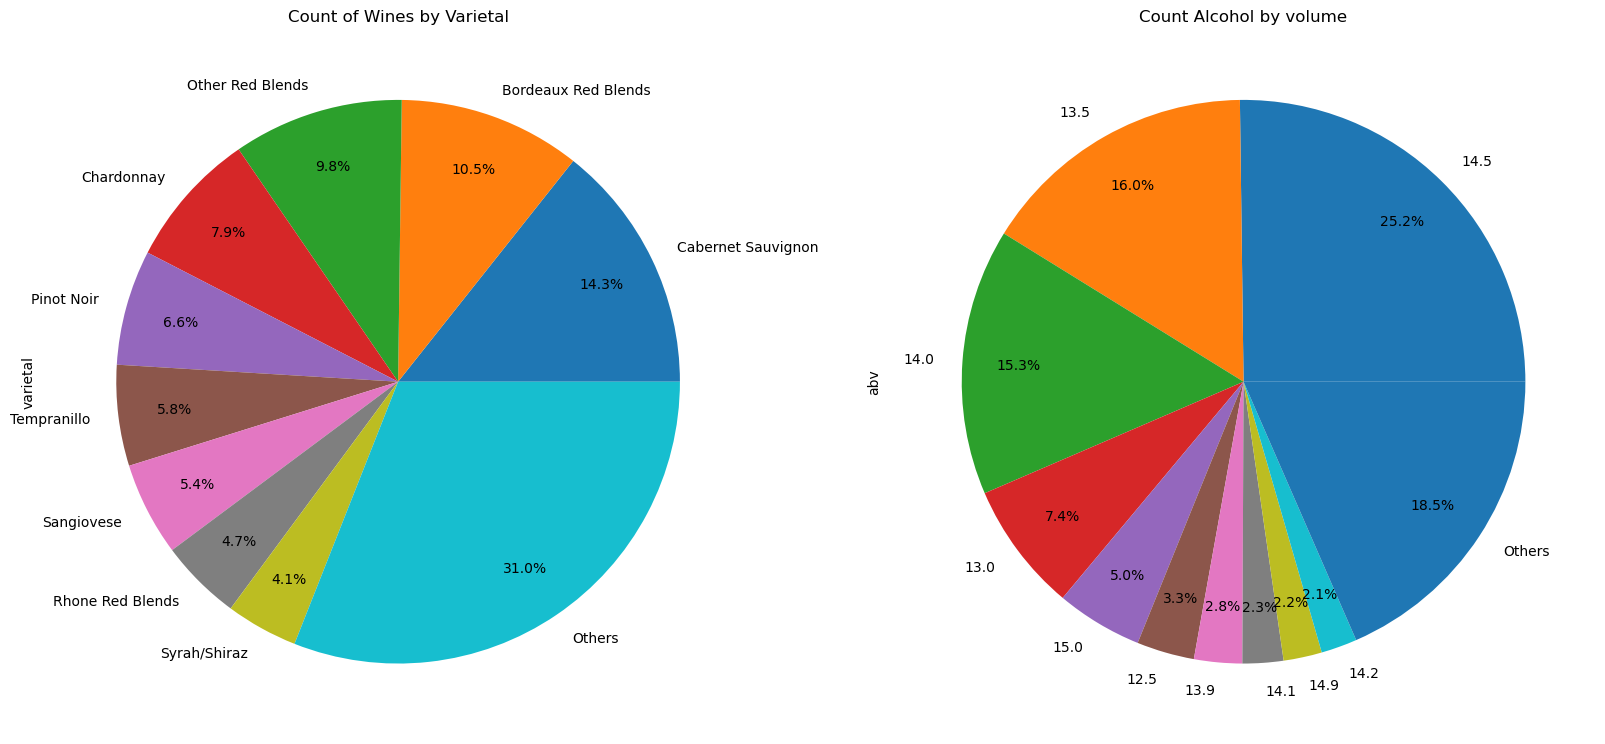

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
fig1, (ax3,ax4) = plt.subplots(1,2, figsize=(20,10))

df_origin = df['origin'].value_counts()
others = df_origin[df_origin <= df_origin.sum() * 0.01].sum()
df_origin = df_origin[df_origin > df_origin.sum() * 0.01]
df_origin['Others'] = others
df_origin.plot.pie(y='origin', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax1)

df_year = df['year'].value_counts()
others = df_year[df_year <= df_year.sum() * 0.02].sum()
df_year = df_year[df_year > df_year.sum() * 0.02]
df_year['Others'] = others
df_year.plot.pie(y='year', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax2,startangle=90)

df_varietal = df['varietal'].value_counts()
others = df_varietal[df_varietal <= df_varietal.sum() * 0.04].sum()
df_varietal = df_varietal[df_varietal > df_varietal.sum() * 0.04]
df_varietal['Others'] = others
df_varietal.plot.pie(figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax3)

df_abv = df['abv'].value_counts()
others = df_abv[df_abv <= df_abv.sum() * 0.02].sum()
df_abv = df_abv[df_abv > df_abv.sum() * 0.02]
df_abv['Others'] = others
df_abv.plot.pie(figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax4)

ax1.set_title("Count of Wines by Origin")
ax2.set_title('Count of Wines by Year')
ax3.set_title('Count of Wines by Varietal')
ax4.set_title('Count Alcohol by volume')
plt.show()

### Most of the wine is made in California
### Most of the wine is produced in 2019
### The most common varietal is Cabernet Sauvignon
### Most of the wine has 14.5% alcohol

**---------------------------------------------------------------------------------------------------------------------------**

# Regression vs. Classification

# Setting up everything for machine learning (Regression)

**Divide into independent and dependent variables**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df.drop(columns=['rating','product_name','varietal','origin','reviews'])
vectorizer = TfidfVectorizer()
reviews = vectorizer.fit_transform(df['reviews'])
varietal_dummies = pd.get_dummies(df['varietal'])
origin_dummies = pd.get_dummies(df['origin'])
X = np.concatenate((X, varietal_dummies, origin_dummies), axis=1)
y = df['rating']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Classify function takes a model, a set of training data (x_train and y_train), and a set of test data (x_test and y_test) as input, and it performs several tasks related to evaluating the performance of the model**

In [24]:
def classify(model, x_train, x_test, y_train, y_test):
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    y_pred = model.predict(x_test)
    # evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    print("CV Score:", np.mean(score)*-1)
    plt.scatter(y_pred, y_test, c='red', alpha=0.5, s=50, label='Predicted values')
    plt.scatter(y_test, y_pred, c='blue', alpha=0.5, s=50, label='True values')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title('Predicted vs. true values')
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    plt.show()
    return model, y_pred, mae

# Starting machine learning (Regression)

**Linear Regression**

Accuracy: 23.500850434024333
Mean Absolute Error: 0.25894508968981483
CV Score: 0.28565086645019366


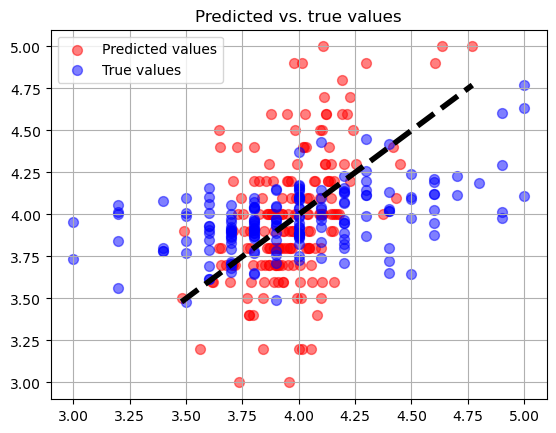

In [25]:
from sklearn.linear_model import LinearRegression
LinearRegression = LinearRegression()
trained_model, y_pred_lr , accuracy_lr = classify(LinearRegression, x_train, x_test, y_train, y_test)

**Decision Tree Regressor**

Accuracy: -31.114446709797548
Mean Absolute Error: 0.34615384615384615
CV Score: 0.3477836561171469


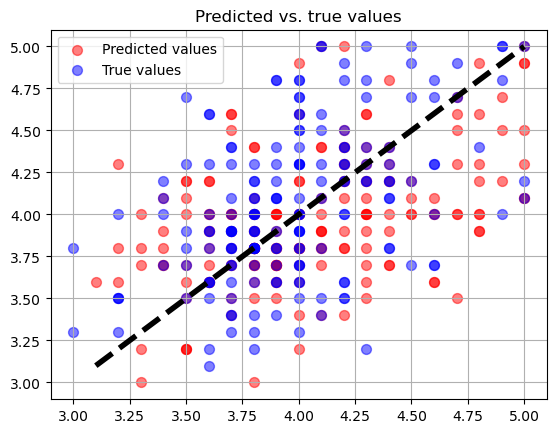

In [26]:
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor = DecisionTreeRegressor()
trained_model, y_pred_dt , accuracy_dt = classify(DecisionTreeRegressor, x_train, x_test, y_train, y_test)

**Random Forest Regressor**

Accuracy: 36.27102699426877
Mean Absolute Error: 0.24570879120879144
CV Score: 0.24416427964100143


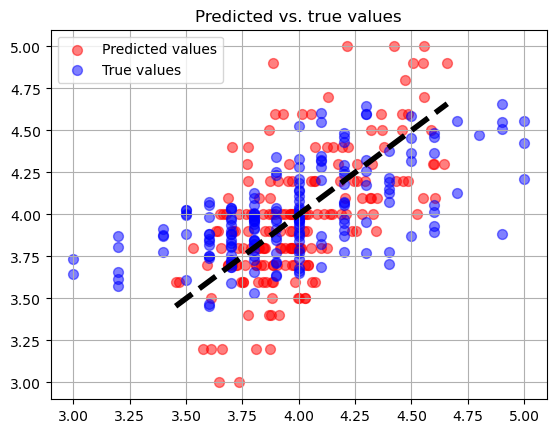

In [27]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()
trained_model, y_pred_rf , accuracy_rf = classify(random_forest, x_train, x_test, y_train, y_test)

**Extra Trees Regressor**

Accuracy: 27.542194097060424
Mean Absolute Error: 0.25977472527472567
CV Score: 0.25763507794048185


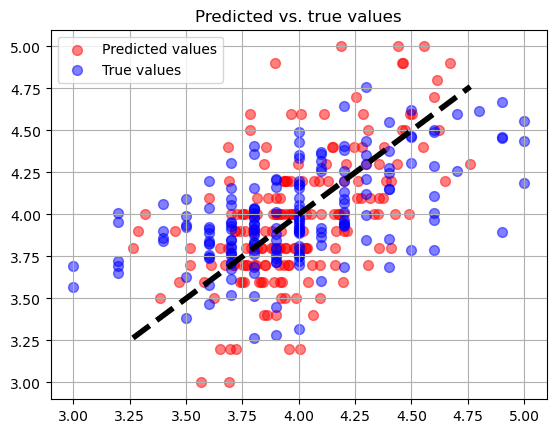

In [28]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor()
trained_model, y_pred_et , accuracy_et = classify(extra_trees_model, x_train, x_test, y_train, y_test)

**SVR**

Accuracy: 18.29126825346259
Mean Absolute Error: 0.26894662075170417
CV Score: 0.28208220147455315


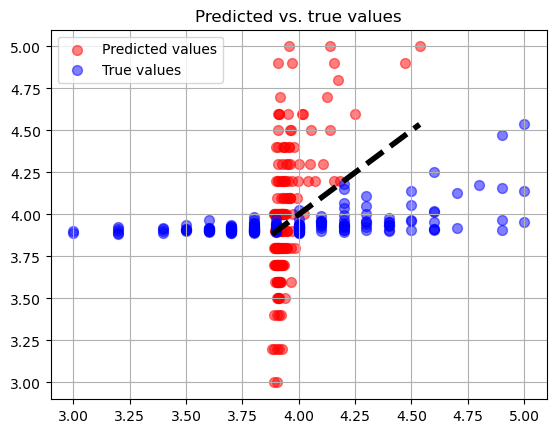

In [29]:
from sklearn.svm import SVR
svr_model = SVR()
trained_model, y_pred_sv , accuracy_sv = classify(svr_model, x_train, x_test, y_train, y_test)

**We are unable to use those models because they are inaccurate. We will try to find a new approach!**

# Setting up everything for machine learning (Classification)

**Create a new column called quality in the DataFrame, which contains the labels for the categories that each value in the rating column belongs to**

In [30]:
df['rating'].value_counts()
names = ['poor', 'high']
bins = (3.0, 4.1, 5.0)
df['quality'] = pd.cut(df['rating'], bins = bins, labels = names)

**Display a bar chart that shows the counts of each category in the quality column of the DataFrame**

Text(0.5, 1.0, 'Quality of Wine')

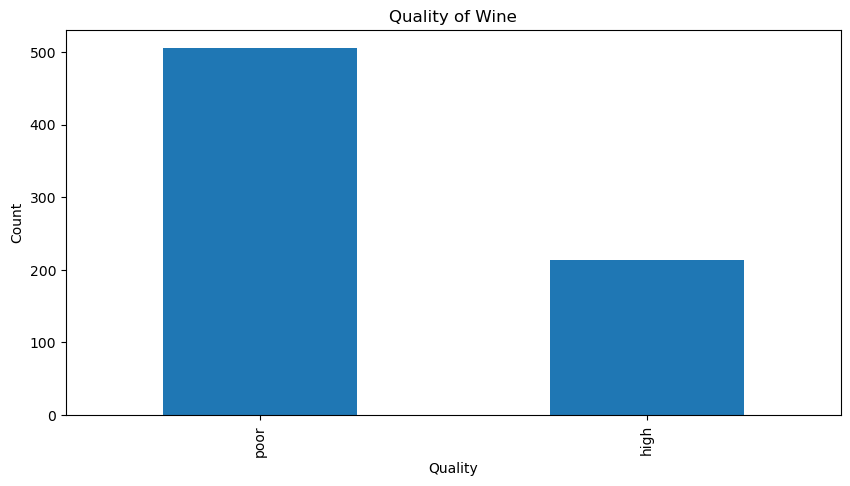

In [31]:
df['quality'].value_counts().plot.bar(figsize=(10, 5))
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Quality of Wine')

**Convert the values in the quality column of the DataFrame to numerical values**

In [33]:
df = df.dropna(subset=['quality'])
df['quality'] = df['quality'].replace({'high': 1, 'poor': 0})
df['quality'] = df['quality'].astype(int)
df

,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews,varietal_code,origin_code,quality
0,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,90,commentary the 2019 duckhorn vineyards caberne...,4,4,1
1,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,20,the purity of fruit is really something else h...,2,4,1
2,Silver Oak Alexander Valley Cabernet Sauvignon,2018,Cabernet Sauvignon,California,89,14.4,4.6,31,commentary the silver oak alexander valley one...,4,4,1
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,82,14.5,4.4,101,cassis dried blueberries violets ink graphite ...,4,4,1
4,Antinori Marchese Chianti Classico Riserva,2019,Sangiovese,Italy,46,14.0,4.3,11,a harmonious red offering an expression of che...,31,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
721,Serego Alighieri MontePiazzo Valpolicella Clas...,2017,Other Red Blends,Italy,41,13.5,3.7,17,a valpo with lots of crushedberry chocolate an...,20,8,0
722,Langmeil The Blacksmith Cabernet Sauvignon,2017,Cabernet Sauvignon,Australia,32,14.5,4.2,23,brilliant ruby ripe cherry and blackcurrant ar...,4,2,1
723,Vinaceous Reverend V Cabernet Sauvignon,2014,Cabernet Sauvignon,Australia,19,14.5,3.5,30,the mintscented 2014 right reverend v cabernet...,4,2,0
724,Enrique Mendoza Estrecho Monastrell,2016,Mourvedre,Spain,40,14.0,3.8,10,the 2016 estrecho was cropped from a more unus...,15,11,0


**Divide into independent and dependent variables**

In [34]:
X = df.drop(columns=['rating','product_name','varietal','origin','quality', 'reviews'])
vectorizer = TfidfVectorizer()
reviews = vectorizer.fit_transform(df['reviews'])
varietal_dummies = pd.get_dummies(df['varietal'])
origin_dummies = pd.get_dummies(df['origin'])
X = np.concatenate((X, varietal_dummies, origin_dummies), axis=1)
y = df['quality']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Classify function takes a model, a set of training data (x_train and y_train), and a set of test data (x_test and y_test) as input, and it performs several tasks related to evaluating the performance of the model**

In [35]:
from sklearn.metrics import f1_score
def classify(model, x_train, x_test, y_train, y_test):
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    # cross-validation
    score = cross_val_score(model, X, y, cv=5)
    print("CV Score:", np.mean(score)*100)
    print("F1 Score:", f1)
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, columns=['0', '1'])
    print(matrix)
    matrix.plot(kind='bar')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model, y_pred, accuracy

In [36]:
models = []
models_accuracies = []


# Starting machine learning (Classification)

**Logistic Regression**

Accuracy: 83.33333333333334
CV Score: 80.35353535353536
F1 Score: 0.6666666666666667
     0   1
0  120   7
1   23  30


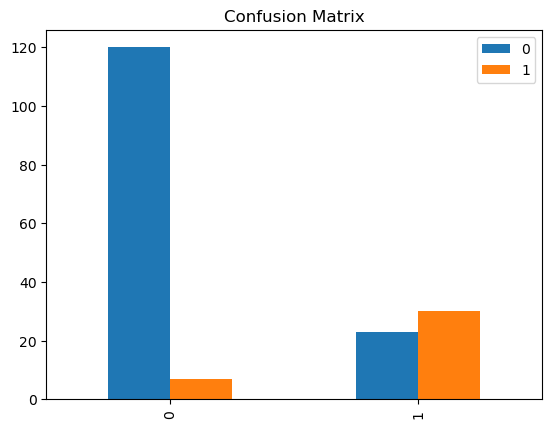

In [37]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1500)
trained_model, y_pred_lr , accuracy_lr = classify(logistic_regression, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Decision Tree Classifier**

Accuracy: 74.44444444444444
CV Score: 70.75563325563327
F1 Score: 0.6101694915254237
    0   1
0  98  29
1  17  36


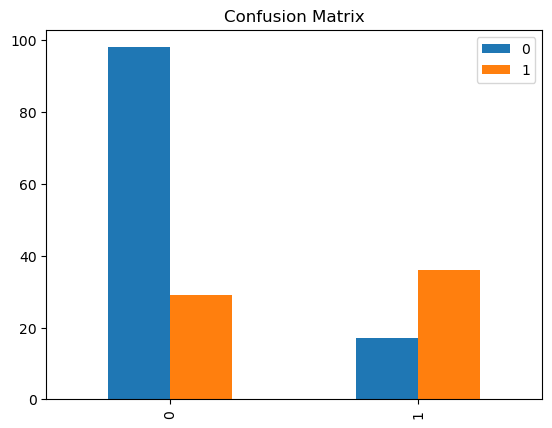

In [38]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
trained_model, y_pred_dt , accuracy_dt = classify(decision_tree, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_dt)

**Random Forest Classifier**

Accuracy: 81.11111111111111
CV Score: 77.8467365967366
F1 Score: 0.66
     0   1
0  113  14
1   20  33


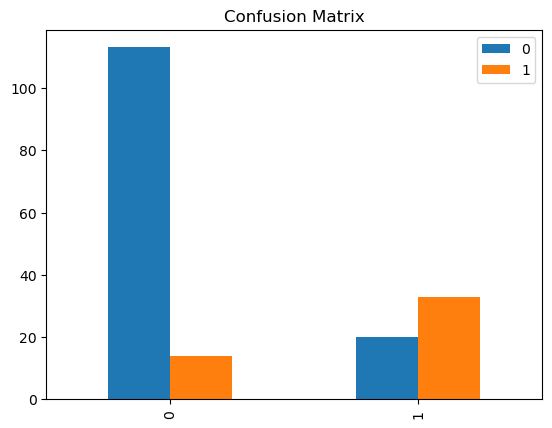

In [39]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
trained_model, y_pred_rf , accuracy_rf = classify(random_forest, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_rf)

**Extra Trees Classifier**

Accuracy: 75.0
CV Score: 74.22591297591298
F1 Score: 0.5544554455445545
     0   1
0  107  20
1   25  28


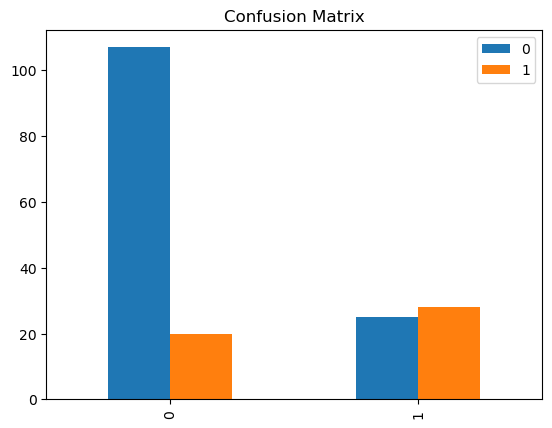

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_model = ExtraTreesClassifier()
trained_model, y_pred_et , accuracy_et = classify(extra_trees_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_et)

**AdaBoost**

Accuracy: 81.11111111111111
CV Score: 78.12839937839937
F1 Score: 0.6530612244897959
     0   1
0  114  13
1   21  32


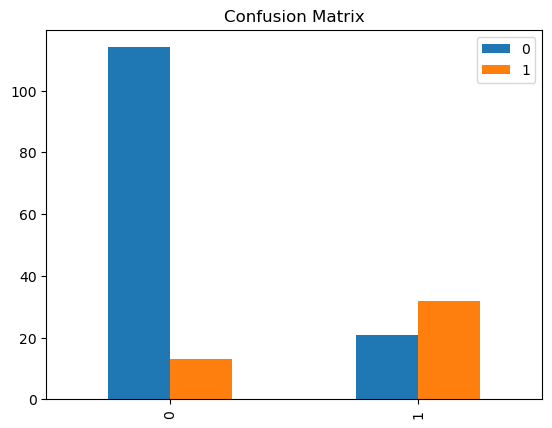

In [41]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
trained_model, y_pred_ada , accuracy_ada = classify(ada_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_ada)

**Gradient Boosting**

Accuracy: 82.22222222222221
CV Score: 77.983682983683
F1 Score: 0.6862745098039216
     0   1
0  113  14
1   18  35


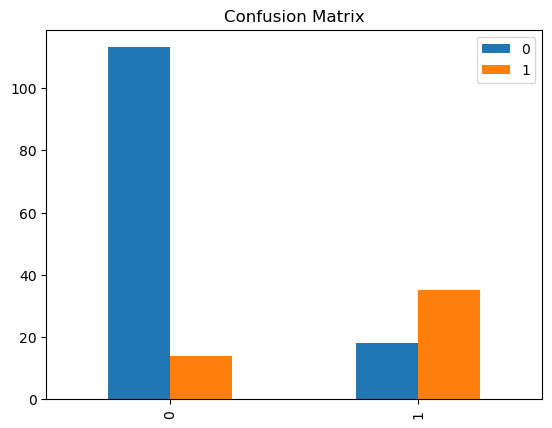

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier()
trained_model, y_pred_gbc , accuracy_gbc = classify(gbc_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_gbc)

**LightGBM**

Accuracy: 78.88888888888889
CV Score: 75.62257187257188
F1 Score: 0.6481481481481481
     0   1
0  107  20
1   18  35


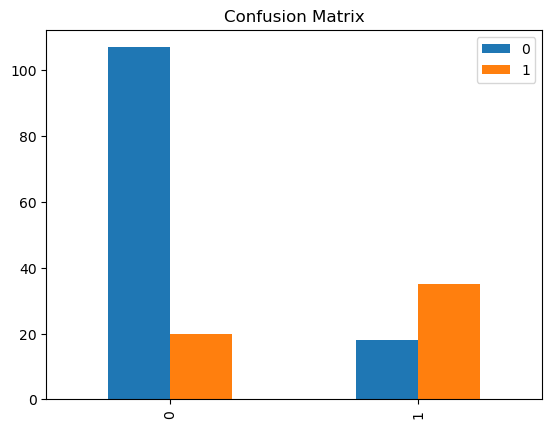

In [43]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier()
trained_model, y_pred_lgbm , accuracy_lgbm = classify(lgbm_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lgbm)

**Multi-layer Perceptron classifier**

Accuracy: 80.55555555555556
CV Score: 78.54700854700855
F1 Score: 0.5454545454545454
     0   1
0  124   3
1   32  21


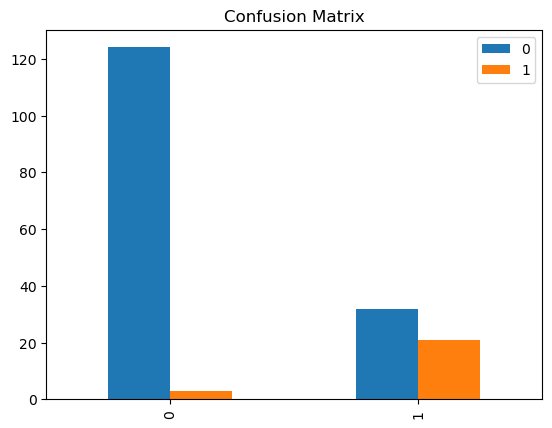

In [44]:
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(max_iter=1000)
trained_model, y_pred_lr , accuracy_lr = classify(nn_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Support Vector Classifier**

Accuracy: 80.55555555555556
CV Score: 80.07575757575758
F1 Score: 0.5977011494252874
     0   1
0  119   8
1   27  26


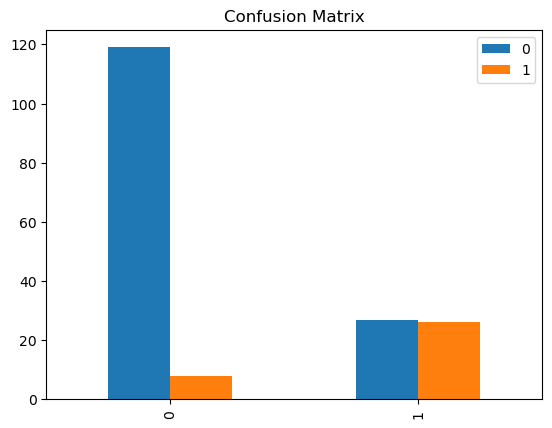

In [45]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
trained_model, y_pred_lr , accuracy_lr = classify(svm_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Naive Bayes**

Accuracy: 35.0
CV Score: 42.33391608391609
F1 Score: 0.45070422535211263
    0    1
0  15  112
1   5   48


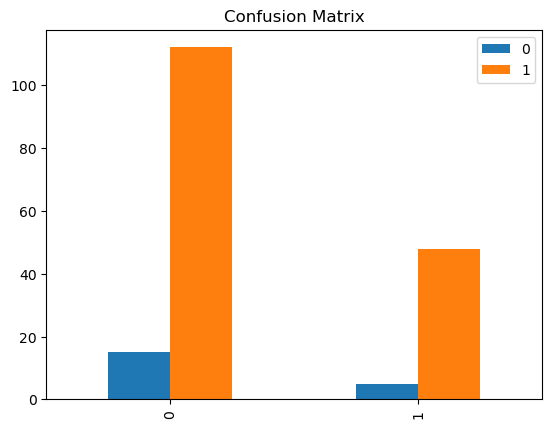

In [46]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
trained_model, y_pred_nb , accuracy_nb = classify(nb_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_nb)

**Display a summary of the results of training and evaluating several machine learning models**

In [47]:
models_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting', 'LightGBM', 'MLP', 'SVC', 'Naive Bayes']
for model, acc in zip(models_names, models_accuracies):
    print(f'Model: {model}, score: {acc} ')

Model: Logistic Regression, score: 0.8333333333333334 
Model: Decision Tree, score: 0.7444444444444445 
Model: Random Forest, score: 0.8111111111111111 
Model: Extra Trees, score: 0.75 
Model: AdaBoost, score: 0.8111111111111111 
Model: Gradient Boosting, score: 0.8222222222222222 
Model: LightGBM, score: 0.7888888888888889 
Model: MLP, score: 0.8055555555555556 
Model: SVC, score: 0.8055555555555556 
Model: Naive Bayes, score: 0.35 


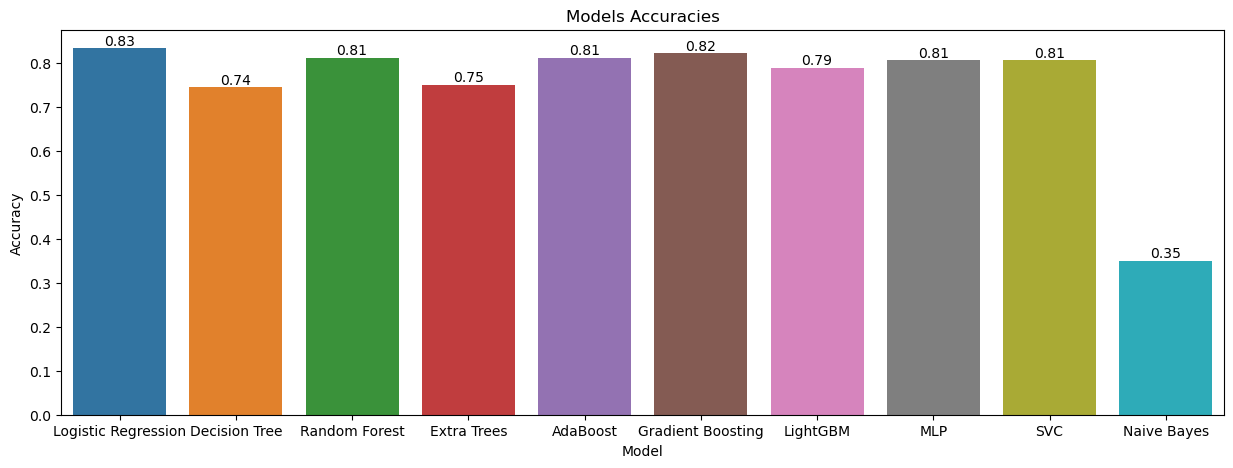

In [48]:
plt.figure(figsize=(15,5))
sns.barplot(x=models_names, y=models_accuracies)
for i, v in enumerate(models_accuracies):
    plt.text(i, v, f"{v:.2f}", va="bottom", ha="center")
plt.title('Models Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

**Contain the trained machine learning model that achieved the highest accuracy score among all of the models in the models list**

In [49]:
max_index = models_accuracies.index(max(models_accuracies))
best_model = models[max_index]
best_model

LogisticRegression(max_iter=1500)